In [2]:
# All of our imports
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import emoji
from emoji_translate.emoji_translate import Translator
import advertools as adv
import regex as re


In [3]:
# Initalizes a base directory
base_direct = "archive_og"

In [29]:
# Initalizes our VGG16 model
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
# Preprocessing each image
features = {}
directory = os.path.join(base_direct, "Images")

for img_name in os.listdir(directory):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

In [31]:
# pickle.dump(features, open("features.pkl", "wb"))
# with open("features.pkl", "rb") as f:
#     features = pickle.load(f)
# with open("features.pkl", "wb") as f:
#     pickle.dump(features, f)
# with open("features.pkl", "rb") as f:
#     features = pickle.load(f)

In [32]:
# Opens the caption file
with open(os.path.join(base_direct, "captions.txt")) as f:
    next(f)
    captions_doc = f.read()

# Seperate the image id from the caption and adds it to the mapping dictionary
mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
print(f"Total Amount of Images: {len(mapping)}")

Total Amount of Images: 8091


In [54]:
# Cleans the captions
def clean(mapping):
    for id, captions in mapping.items():
        for x in range(len(captions)):
            caption = captions[x]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = " ".join(caption.split())
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[x] = caption

clean(mapping)

In [55]:
# Creates a list of all the captions
all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

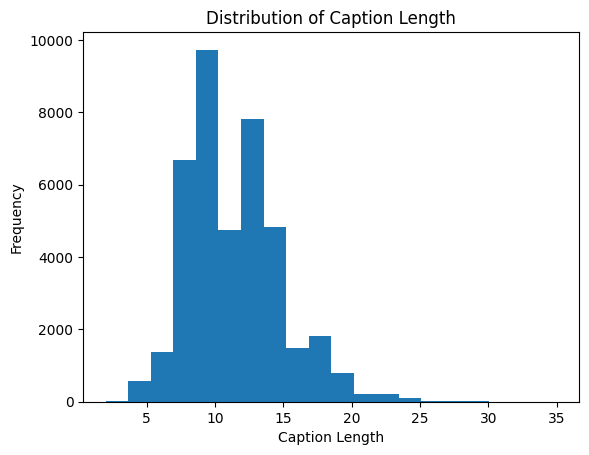

In [56]:
# Get the length of each caption in all_cap and plots the distribution
caption_lengths = [len(caption.split()) for caption in all_cap]

plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Length')
plt.show()

In [57]:
# Use tokenizer function break down captions into individual words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)

# takes vocab size of our data
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab Size: {vocab_size}")

Vocab Size: 8485


In [58]:
# Counts the frequency of unique words and creates an ordered list of the most frequent words
word_freq = Counter(tokenizer.word_counts)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

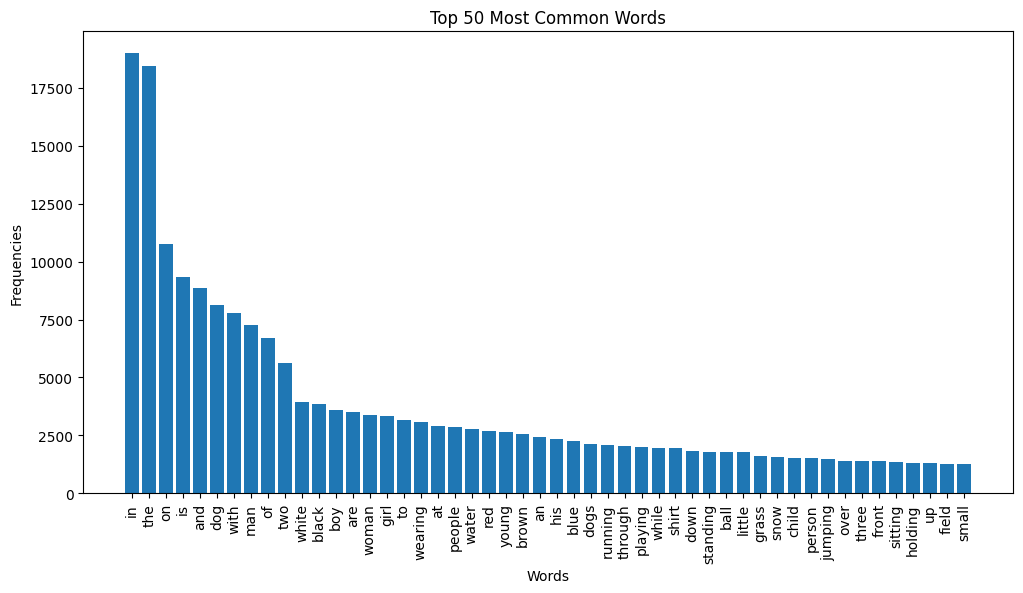

In [59]:

# Separate the words and their frequencies
words, frequencies = zip(*sorted_word_freq[2:52])

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Top 50 Most Common Words')
plt.show()

In [60]:
_, total_frequencies = zip(*sorted_word_freq)
frequencies_top_50 = total_frequencies[2:52]
total_frequency_top_50 = sum(frequencies_top_50)
total_frequency = sum(total_frequencies[2:])
print(total_frequency_top_50)
print(total_frequency)


191135
375705


In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate the words and their frequencies
words, frequencies = zip(*sorted_word_freq[-20:])
df = pd.DataFrame(words)
df_transposed = df.transpose()
df_transposed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,slat,driftrood,sunlit,consumer,bodysurfs,ever,since,started,pinball,keffiyahs,swatting,containig,rainstorm,breezeway,cocker,spaniels,weight,majestically,scrolled,patterns


In [62]:
import pandas as pd

# Create a dataframe with sorted_word_freq
df = pd.DataFrame(sorted_word_freq, columns=['Word', 'Frequency'])

# Filter the dataframe to include only words with 1 occurrence
df_filtered = df[df['Frequency'] == 1]

# Display the filtered dataframe
len(df_filtered)
print(f'Count of Unique Words: {len(df_filtered)}')

Count of Unique Words: 3339


In [63]:
max_length = max(len(caption.split()) for caption in all_cap)
max_length
print(f'Maximum length of characters in a caption: {max_length}')

Maximum length of characters in a caption: 35


In [64]:
#train test split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.05, random_state = 10)

In [65]:
#getting batch, for sequence to sequence model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for c in captions:
                seq = tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [66]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [67]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [68]:
# epochs = 100
# batch_size = 16
# steps = len(train) // batch_size

# for i in range(epochs):
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [69]:
# model.save('./best_model.keras')

In [70]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [71]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [211]:
new_model = load_model('./best_model.keras')

In [212]:
# Creates a function that generates the predicted caption and displays both the actual and predicted caption
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_direct, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("-----------Original Descriptions of the Image-----------")
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(new_model, features[image_id], tokenizer, max_length)
    print("-----------Predicted Description of the Image-----------")
    print(y_pred)
    plt.imshow(image)
    return y_pred

-----------Original Descriptions of the Image-----------
startseq small dog jumps over jump endseq
startseq small white dog is jumping over green and red obstacle bar endseq
startseq white dog runs through an obstacle course endseq
startseq the white dog is jumping over hurdles endseq
startseq the white dog is leaping over red and green fence on an obstacle course endseq
-----------Predicted Description of the Image-----------
startseq small white and white dog jumps over red hurdle endseq


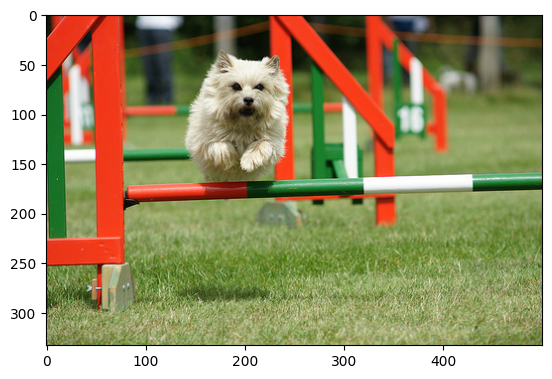

In [213]:
# Tests captions
testing = test[2]
caption_tested = generate_caption(testing + ".jpg")

In [195]:
# Add all caption words to all_cap_and_test and makes the caption lowercase
caption_words = ' '.join(caption_tested.split()[1:-1])
all_cap_and_test = all_cap.copy()
all_cap_and_test.append(caption_words)
all_cap_lower = [x.lower() for x in all_cap_and_test]
print(all_cap_lower[-1])

football players in red uniforms are getting ready to tackle football


In [185]:
# Creates a list with the words in the caption
arr = []
arr = all_cap_lower[-1].split(" ")
print(arr)

['an', 'old', 'man', 'in', 'blue', 'coat', 'is', 'reading', 'something', 'down', 'by', 'building']


In [186]:
tfid_vec = TfidfVectorizer()
X = tfid_vec.fit_transform(all_cap_lower)

In [187]:
# Removes unneeded endings for words and makes exceptions for certain words
emojii = Translator(exact_match_only = False, randomize = True)
cap_vocab = tfid_vec.get_feature_names_out()[np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word.endswith("ss"):
        cap_vocab[i] = word
    else:
        if word.endswith("s"):
            cap_vocab[i] = word[:-1] 
    if word.endswith("es"):
        cap_vocab[i] = word[:-1]
    elif word.endswith("ing"):
        cap_vocab[i] = word[:-3]
    elif word.endswith("ed"):
        if word == "red":
            break
        cap_vocab[i] = word[:-2]
    elif word.endswith("y"):
        if word == "boy":
            break
        cap_vocab[i] = word[:-1]
    
print(cap_vocab)

['an' 'blue' 'build' 'b' 'coat' 'down' 'in' 'i' 'man' 'old' 'read'
 'someth']


In [188]:
# Modifies colors to be identified as certain heart emojis and emojifies words that corresponds with emojis
colors = ["red", "orange", "yellow", "green", "blue", "purple", "white", "black", "brown"]
caption_emoji = []
for word in cap_vocab:
    if word in colors:
        if word == "red":
            word = emoji.emojize(":heart:")
        else:
            word = emoji.emojize(":" + word +"_heart:")
    caption_emoji.append(emojii.emojify(word))

print(caption_emoji)

['an', '💙', '👷\u200d♀️', '🅱️', '🧥', 'down', 'in', 'i', '👨', '👵', '📕', 'someth']


In [189]:
# Removes non emojified words and removes emoji unicode
copy_caption_emoji = caption_emoji.copy()

for i, word in enumerate(caption_emoji):
    graphemes =re.findall(r'\X', word)
    result = "".join([grapheme for grapheme in graphemes if re.match(r'^\p{Emoji}(\uFE0F\u20E3?|[\p{Emoji}\u200D])*$', grapheme)])
    copy_caption_emoji[i] = result

while "" in copy_caption_emoji:
    copy_caption_emoji.remove("")

print(copy_caption_emoji)

['💙', '👷\u200d♀️', '🅱️', '🧥', '👨', '👵', '📕']


In [190]:
# creates a dictionary containing the emojified words and their calculated weights
dic = {}
cap_weights = X.toarray()[-1][np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word not in caption_emoji:
        dic[word] = cap_weights[i]


print(dic)
print(list(dic.keys()))

{'blue': 0.2366629092717407, 'build': 0.32483232489048375, 'b': 0.2712241739351151, 'coat': 0.3643128044915601, 'man': 0.16641282327436732, 'old': 0.3896330087402667, 'read': 0.4246957275335695}
['blue', 'build', 'b', 'coat', 'man', 'old', 'read']


In [191]:
# 
def pick_closest_values(arr):
    dict = {}
    for x in range(len(arr)):
        dict[list(arr.values())[x]] = x
    closest_values = sorted(dict.keys(), reverse = False)
    closest_indexes = []
    if len(arr) == 1:
        ret = [0,0,0]
        return ret
    if len(arr) == 2:
        ret = [0,1,0]
        return ret
    for x in range(len(closest_values[:3])):
        closest_indexes.append(dict[closest_values[x]])
    return closest_indexes

👨 💙 🅱️


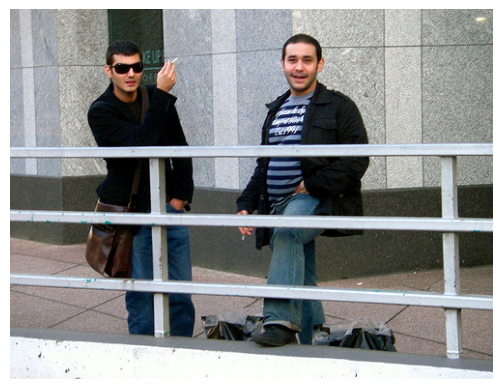

In [192]:
# Get indices of the choosen words and returns the emojis
top_indexes = pick_closest_values(dic)

top_words = []
for x in top_indexes:
    copy_caption_emoji[x] = copy_caption_emoji[x].split("\u200d")[0]
    top_words.append(copy_caption_emoji[x])
image_id = testing.split('.')[0]
img_path = os.path.join(base_direct, "Images", str(testing) + ".jpg")
image = Image.open(img_path)
string = " ".join(map(str, top_words))

print(string)
plt.imshow(image)
plt.axis("off")
plt.show()